In [158]:
# import modules
%matplotlib inline
from IPython.display import clear_output

import os
import pylab
import random
import numpy as np
import pandas as pd
import cPickle as pkl
import theano.tensor as T
import skimage 
from vis import *
from skimage import transform
from scipy.misc import imread, imresize
from skimage.exposure import adjust_gamma
from sklearn.cross_validation import train_test_split

from lasagne import layers, updates, nonlinearities, objectives
from nolearn.lasagne import NeuralNet, BatchIterator, visualize


project_root = os.path.join(os.path.expanduser('~'), 
                            'workspace/right_whale')
data_root = os.path.join(project_root, 'data')
img_root = os.path.join(data_root, 'imgs')
subs_root = os.path.join(project_root, 'subs')
model_root = os.path.join(project_root, 'models')

In [159]:
# load train and test 
train = pd.read_csv(os.path.join(data_root, 'train_with_points.csv'))
test = pd.read_csv(os.path.join(data_root, 'sample_submission.csv'))

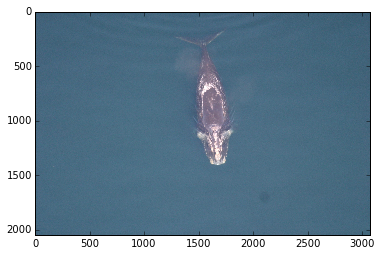

In [160]:
# visualize data
img = imread(data_root+"/train/"+train.Image[0])
pylab.imshow(img)

In [161]:
train.head()

,Image,whaleID,bonnet_tip_x,bonnet_tip_y,blowhead_x,blowhead_y
0,w_7812.jpg,whale_48813,1668.211366,1370.097707,1647.792622,1108.737787
1,w_4598.jpg,whale_09913,1639.625125,1212.873380,1353.762712,1265.962114
2,w_3828.jpg,whale_45062,1118.947159,908.634098,1345.595214,963.764706
3,w_8734.jpg,whale_74162,1690.671984,1223.082752,1682.504487,1069.942173
4,w_3251.jpg,whale_99558,1655.960120,1071.984048,1662.085743,878.005982


In [162]:
SEED = 1

np.random.seed(SEED)

train_ix, val_ix = train_test_split(np.arange(len(train.Image)), test_size=0.2)

In [163]:
# generate batch of images and blowhole masks

def batch(ix, N, seed):
    X = np.zeros((N, 3, 320, 320)).astype('float32')
    Mask = np.zeros((N, 2, 320, 320)).astype('float32')
    
    rng = np.random.RandomState(seed)
    ix = ix[rng.randint(0, len(ix), N)]
    for n, i in enumerate(ix):
        im = imread('{}/{}'.format(img_root, train.ix[i, 0]))
        im = imresize(im, (im.shape[0]*320/im.shape[1], 320))
        temp = (320 - im.shape[0])//2
        im = np.pad(im, [(temp, temp), (0, 0), (0, 0)], mode='constant')
        im = imresize(im, (320, 320))

        
        im = im/255. - 0.5
        mask = np.zeros(im.shape[:2])

        x1, y1 = train.ix[i, 2], train.ix[i, 3]
        x1 = int(x1/320)
        y1 = int(y1/320)
        try:
            mask[y1, x1] = 1
        except IndexError:
            pass

        Mask[n, 0] = mask

        mask = np.zeros(im.shape[:2])
        x1, y1 = train.ix[i, 4], train.ix[i, 5]
        x1 = int(x1/320)
        y1 = int(y1/320)
        try:
            mask[y1, x1] = 1
        except IndexError:
            pass
        
        
        Mask[n, 1] = mask
        X[n] = im.transpose(2, 0, 1)
    return X, Mask

In [164]:
import lasagne
import theano
import theano.tensor as T

from lasagne.layers import InputLayer
from lasagne.layers.dnn import Conv2DDNNLayer as Conv
from lasagne.layers.dnn import Pool2DDNNLayer as Pool
from lasagne.layers import Upscale2DLayer
from lasagne.layers import ConcatLayer

from lasagne.nonlinearities import softmax

In [165]:
# Based on Recombinator Network from http://arxiv.org/abs/1511.07356

def build_net(IMAGE_W):
    net = {}
    l = InputLayer((None, 3, IMAGE_W, IMAGE_W))
    net['input'] = l

    l = Conv(l, 16, 3, pad='same')
    net['T4'] = l

    l = Conv(Pool(l, 2), 32, 3, pad='same')
    net['T3'] = l

    l = Conv(Pool(l, 2), 48, 3, pad='same')
    net['T2'] = l

    l = Conv(Pool(l, 2), 48, 3, pad='same')
    net['T1'] = l

    l = Conv(Conv(net['T1'], 48, 3, pad='same'), 48, 3, pad='same')
    l = Upscale2DLayer(l, 2)
    net['M1'] = l

    l = ConcatLayer((net['T2'], net['M1']))
    l = Conv(Conv(l, 48, 3, pad='same'), 32, 3, pad='same')
    l = Upscale2DLayer(l, 2)
    net['M2'] = l

    l = ConcatLayer((net['T3'], net['M2']))
    l = Conv(Conv(l, 32, 3, pad='same'), 16, 3, pad='same')
    l = Upscale2DLayer(l, 2)
    net['M3'] = l

    l = ConcatLayer((net['T4'], net['M3']))
    l = Conv(Conv(l, 16, 3, pad='same'), 2, 3, pad='same', nonlinearity=None)
    
    l = lasagne.layers.ReshapeLayer(l, (-1, IMAGE_W*IMAGE_W))
    l = lasagne.layers.NonlinearityLayer(l, softmax)
    l = lasagne.layers.ReshapeLayer(l, (-1, 2, IMAGE_W, IMAGE_W))
    net['M4'] = l

    return net

In [166]:
IMAGE_W = 320

lasagne.random.set_rng(np.random.RandomState(SEED))

net = build_net(IMAGE_W)
pv0 = lasagne.layers.get_all_param_values(net['M4'])

In [167]:
X = T.tensor4()
Y = T.tensor4()
output = lasagne.layers.get_output(net['M4'], X)

loss = lasagne.objectives.binary_crossentropy(output.reshape((-1, IMAGE_W*IMAGE_W)),
                                              Y.reshape((-1, IMAGE_W*IMAGE_W))
                                             )
loss = T.mean(loss)

params = lasagne.layers.get_all_params(net['M4'])

LR = theano.shared(np.array(0.0001).astype('float32'))
updates = lasagne.updates.adam(loss, params, learning_rate=LR)

In [168]:
f_predict = theano.function([X], output)
f_train = theano.function([X, Y], loss, updates=updates)
f_val = theano.function([X, Y], [loss, output])

In [169]:
def maxloc(mask):
    a = mask.reshape((-1, IMAGE_W*IMAGE_W)).argmax(-1)
    y = a % IMAGE_W
    x = a // IMAGE_W
    return np.array((y, x)).T

def l2dist(x1, x2):
    return np.sqrt(((x1 - x2)**2).sum(-1))

In [170]:
rng = np.random.RandomState(SEED)

for epoch in range(1):
    train_loss = 0
    for _ in range(10):
        Xb, Mb = batch(train_ix, 24, rng.randint(4294967295))
        train_loss += f_train(Xb, Mb)
    train_loss /= 10
    val_dist = []
    val_loss = 0
    for _ in range(10):
        Xb, Mb = batch(val_ix, 24, rng.randint(4294967295))
        loss, Pb = f_val(Xb, Mb)
        val_loss += loss
        val_dist.append(l2dist(maxloc(Mb), maxloc(Pb)))
    val_dist = np.concatenate(val_dist)
    val_loss /= 10
    print('Epoch {:03}: loss train (val) {:.07f} ({:.07f}) mean dist {:.01f}, nearby {:.03f}'.format(
            epoch, train_loss, val_loss, val_dist.mean(), (val_dist < 10).mean()))

Epoch 000: loss train (val) 0.0001223 (0.0001221) mean dist 322.1, nearby 0.025


In [171]:
# try predicting on test image
im = imread('../data/test/w_10006.jpg')

im = skimage.transform.resize(im, (im.shape[0]*320/im.shape[1], 320))
a = (320 - im.shape[0]) // 2 + 1
im = np.pad(im, [(a, a), (0, 0), (0, 0)], mode='constant', constant_values=0.5)
im = im[:320, :320].transpose(2, 0, 1)[np.newaxis] - 0.5

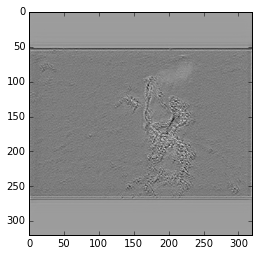

In [172]:
p = f_predict(im.astype('float32'))
p /= p.max()
pylab.imshow(p[0,0])
pylab.gray()

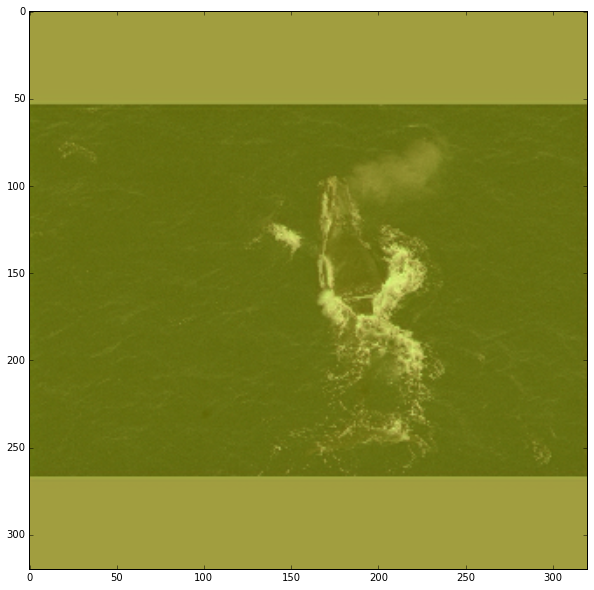

In [173]:
pylab.figure(figsize=(10, 10))
a = 0.5*(im[0].transpose(1,2,0)+0.5) + 0.5*p[0,0][:,:,np.newaxis]*[1,0,0] + 0.5*p[0,1][:,:,np.newaxis]*[0,1,0]
pylab.imshow(a)

(-0.5, 593.5, 589.5, -0.5)

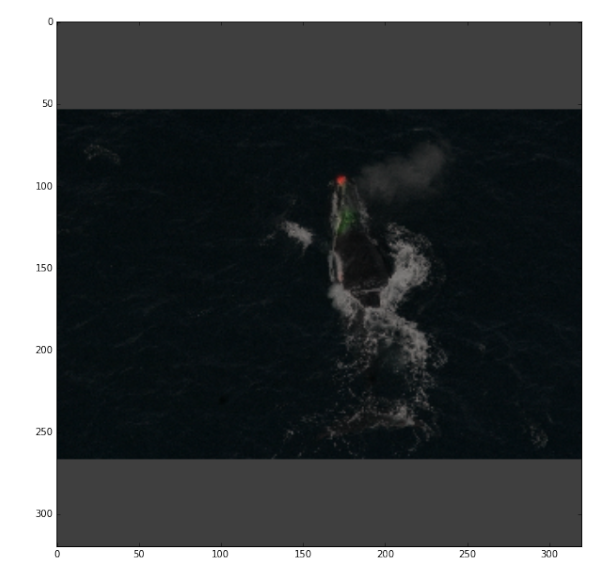

In [174]:
pylab.figure(figsize=(10, 10))
pylab.imshow(imread('./extras/final_pred.png'))
pylab.axis('off')

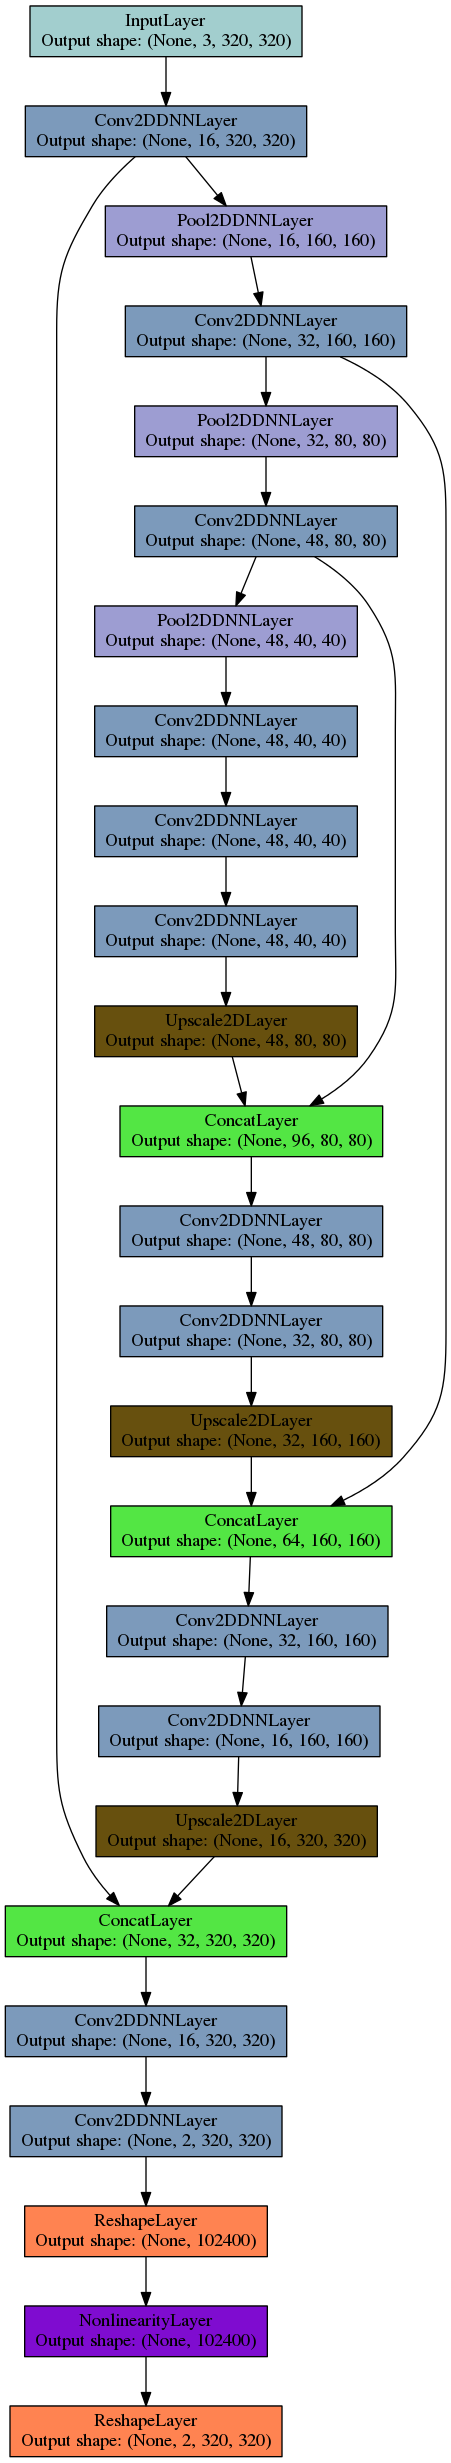

In [175]:
draw_to_notebook(layers.get_all_layers(net['M4']))